In [708]:
# import warnings
warnings.filterwarnings("ignore")

In [709]:
%%capture
!pip install pmdarima
!pip install prophet
!pip install tensorflow

In [710]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [711]:
%matplotlib inline
plt.style.use('bmh')

In [712]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [713]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score

In [714]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

In [715]:
# Setting seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

#### Reading Data

In [717]:
time_series_df = pd.read_csv("../data/gun_violence_cleaned_data_2013_2018.csv")

When analyzing gun violence data, selecting the appropriate time granularity—monthly, weekly, or daily—is crucial to uncovering meaningful patterns and achieving actionable insights. Each level of granularity offers unique advantages and aligns with specific analytical goals.

**Monthly granularity** is ideal for understanding long-term trends and seasonal patterns in gun violence incidents. By aggregating data at the monthly level, we can minimize short-term fluctuations and focus on broader dynamics, such as increases during specific months or long-term growth/decline trends. This granularity is suitable for policymakers or researchers interested in strategic planning or evaluating the long-term impact of interventions, such as legislative changes or public awareness campaigns.

**Weekly granularity** strikes a balance between detail and clarity, making it effective for medium-term analysis. Aggregating incidents by week smooths daily noise while preserving recurring patterns, such as variations between weekdays and weekends or weekly event-related spikes. This level is especially useful for operational planning, such as resource allocation for law enforcement or healthcare systems, where weekly incident counts provide actionable insights without overwhelming detail.

**Daily granularity** provides the highest level of detail, allowing for the analysis of short-term fluctuations and precise incident timing. This granularity is valuable for identifying immediate patterns, such as responses to specific events, changes in weather, or holidays. It is particularly useful for real-time monitoring or tactical interventions requiring day-by-day decision-making.

For gun violence data, **weekly granularity is often the most practical choice**, as it captures essential patterns, such as weekend spikes, without being overwhelmed by daily noise. It is particularly effective for understanding trends and implementing actionable measures at the community or regional level. However, monthly granularity may be better for high-level policy discussions, while daily granularity is indispensable for detailed investigations or emergency response planning. Ultimately, the choice depends on the analytical objectives and the level of detail required for decision-making.

## Monthly Time Series Analysis

Monthly modifications are being done to the data.

In [721]:
# Converting the 'date' column to a datetime format so we can perform time-based operations on it
time_series_df['date'] = pd.to_datetime(time_series_df['date'])

# Creating a new column 'monthyear' that combines the year and month. 
# This uses the .dt accessor to extract the year and month from each date and stores it as a period (e.g., '2013-01').
time_series_df['monthyear'] = time_series_df['date'].dt.to_period('M')

# Now, we group the data by the 'monthyear' column. This essentially groups the incidents by each unique month.
# The .size() function counts how many incidents occurred in each month, giving us a count of incidents per month.
monthly_incidents = time_series_df.groupby('monthyear').size()

# The groupby operation results in a PeriodIndex, but we need a DatetimeIndex for better compatibility with other time operations.
# So, we convert the PeriodIndex (month-year) to a Timestamp format.
# This ensures the index is now in a standard datetime format (e.g., '2013-01-01').
monthly_incidents.index = monthly_incidents.index.to_timestamp()

It is not exactly resampling in the traditional sense (where we aggregate data based on time periods like months or years), but it is grouping data by month and year to get counts of incidents for each period.

In [723]:
indices = []
for i in range(time_series_df.shape[0]):
    if 'mass' in time_series_df['incident_characteristics'].iloc[i]:
        indices.append(i)
df_mass = time_series_df.iloc[indices]

In [724]:
sns.set_theme(style="whitegrid")

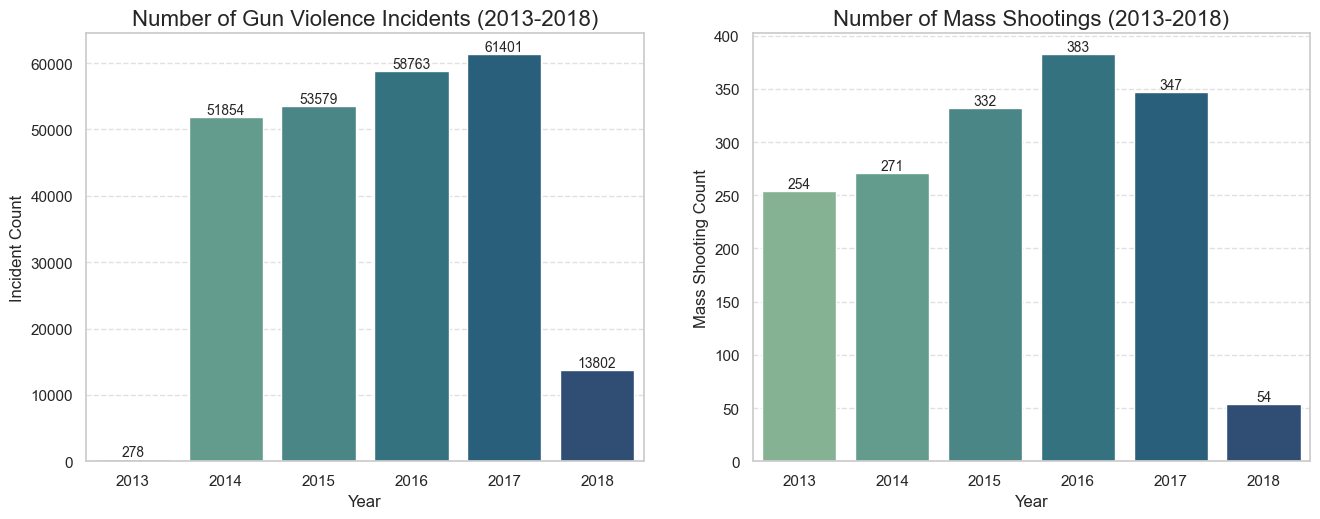

In [725]:
year_palette = sns.color_palette("crest", len(time_series_df['year'].unique()))
plt.figure(figsize=(14, 6))

plt.subplot(121)
ax1 = sns.countplot(x='year', data=time_series_df, order=sorted(time_series_df['year'].unique()), palette=year_palette)
for bar in ax1.patches:
    ax1.annotate(f"{int(bar.get_height())}", 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10)
ax1.set_title('Number of Gun Violence Incidents (2013-2018)', fontsize=16)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Incident Count', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

plt.subplot(122)
ax2 = sns.countplot(x='year', data=df_mass, order=sorted(df_mass['year'].unique()), palette=year_palette)
for bar in ax2.patches:
    ax2.annotate(f"{int(bar.get_height())}", 
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10)
ax2.set_title('Number of Mass Shootings (2013-2018)', fontsize=16)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Mass Shooting Count', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(pad=3)
plt.show()

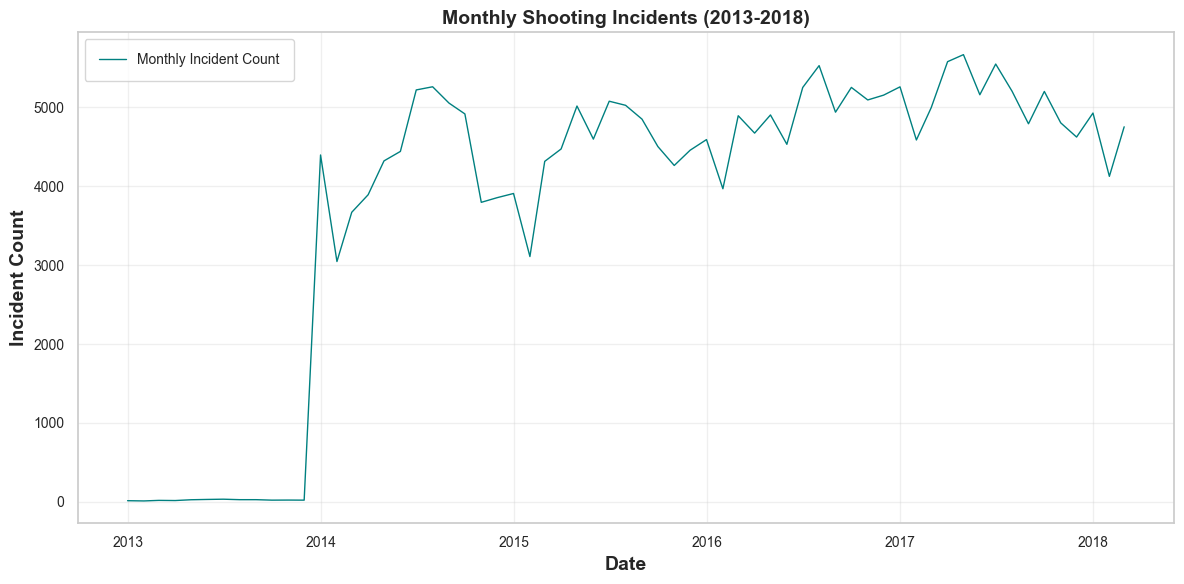

In [726]:
plt.figure(figsize=(12, 6))

plt.plot(monthly_incidents, color='teal', linewidth=1, label="Monthly Incident Count")
plt.title("Monthly Shooting Incidents (2013-2018)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=14, fontweight='bold')
plt.ylabel("Incident Count", fontsize=14, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(alpha=0.3)
plt.legend(loc="upper left", fontsize=10, frameon=True, borderpad=1)
plt.tight_layout()
plt.show()

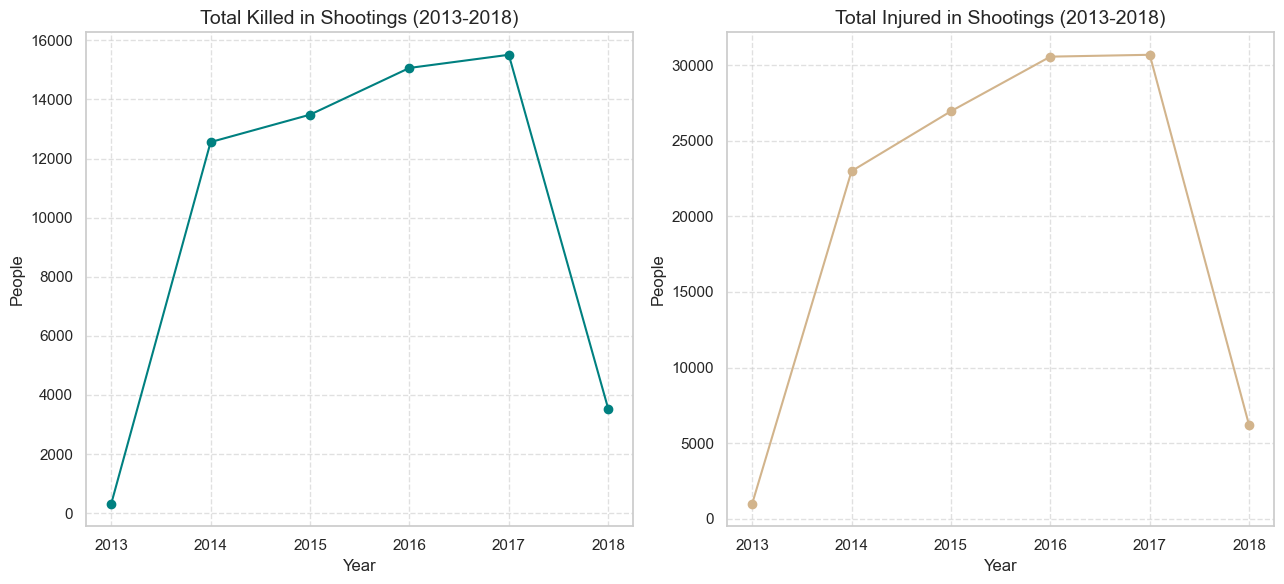

In [727]:
plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.title("Total Killed in Shootings (2013-2018)", fontsize=14)
plt.ylabel("People")
plt.xlabel("Year")
plt.plot(time_series_df.groupby('year')['n_killed'].sum(), marker='o', color='teal', linestyle='-', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(122)
plt.title("Total Injured in Shootings (2013-2018)", fontsize=14)
plt.ylabel("People")
plt.xlabel("Year")
plt.plot(time_series_df.groupby('year')['n_injured'].sum(), marker='o', color='tan', linestyle='-', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

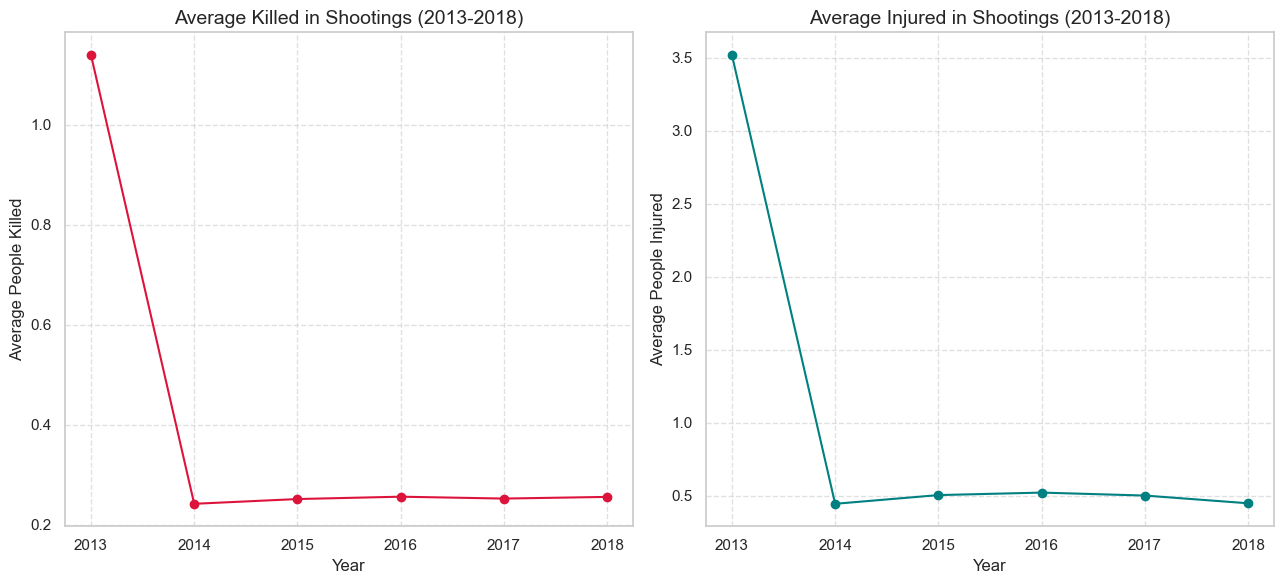

In [728]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.title("Average Killed in Shootings (2013-2018)", fontsize=14)
plt.ylabel("Average People Killed")
plt.xlabel("Year")
plt.plot(time_series_df.groupby('year')['n_killed'].mean(), marker='o', color='crimson', linestyle='-', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(122)
plt.title("Average Injured in Shootings (2013-2018)", fontsize=14)
plt.ylabel("Average People Injured")
plt.xlabel("Year")
plt.plot(time_series_df.groupby('year')['n_injured'].mean(), marker='o', color='teal', linestyle='-', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [729]:
time_series_df['monthyear'] = time_series_df['monthyear'].dt.to_timestamp()

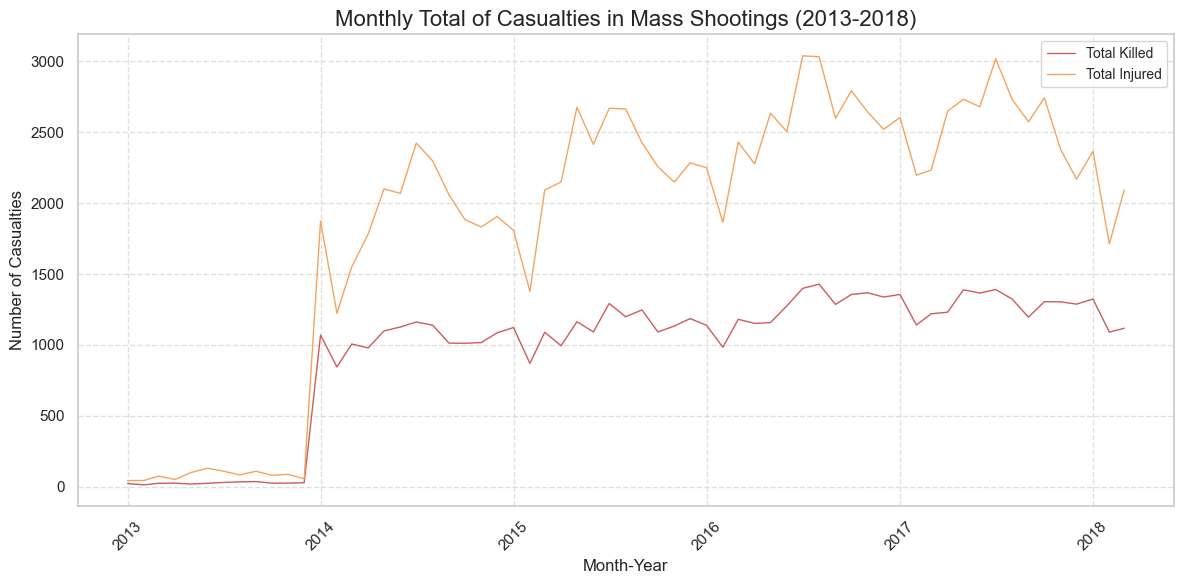

In [730]:
plt.figure(figsize=(12, 6))
plt.plot(time_series_df.groupby('monthyear')['n_killed'].sum(), label='Total Killed', color='indianred', linestyle='-', linewidth=1)
plt.plot(time_series_df.groupby('monthyear')['n_injured'].sum(), label='Total Injured', color='sandybrown', linestyle='-', linewidth=1)

plt.title("Monthly Total of Casualties in Mass Shootings (2013-2018)", fontsize=16)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Number of Casualties", fontsize=12)

plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Time Resampling
Time Resampling is the process of changing the frequency of a time series data, which is often done to aggregate, smooth, or downsample/upscale the data for better analysis or model performance. It involves converting data from one time period to another (e.g., from daily to monthly data) by using functions like summing, averaging, or taking the last value in a given period.

1. Downsampling

    **Definition:** Reducing the frequency of a time series by aggregating data over a longer period. For example, you might convert hourly data into daily or monthly data.


2. Upsampling

    **Definition:** Increasing the frequency of a time series by filling in missing data points. This is typically done with techniques such as interpolation.

In [733]:
resample_df = time_series_df.copy()
resample_df = resample_df.drop("monthyear", axis=1)

In [734]:
resample_df['date'] = pd.to_datetime(resample_df['date'])
resample_df.set_index('date', inplace=True)

In [735]:
monthly_data = resample_df.resample('M').sum()

print(monthly_data[['n_killed', 'n_injured']].head())

            n_killed  n_injured
date                           
2013-01-31        23         44
2013-02-28        14         45
2013-03-31        25         75
2013-04-30        26         52
2013-05-31        20        101


In [736]:
yearly_data = resample_df.resample('A').sum()

print(yearly_data[['n_killed', 'n_injured']].head(10))

            n_killed  n_injured
date                           
2013-12-31       317        979
2014-12-31     12557      23002
2015-12-31     13484      26967
2016-12-31     15066      30580
2017-12-31     15511      30703
2018-12-31      3533       6171


### Augmented Dickey-Fuller (ADF) test

It helps determine if a time series is stationary or non-stationary.

Why the ADF Test is Important:
- The ADF test checks if a time series is stationary, a crucial assumption for many time series models, such as ARIMA.
- Stationary data has constant mean, variance, and autocorrelation over time, making it predictable. Non-stationary data may need transformations, like differencing, to meet model requirements.

A stationary time series has constant statistical properties, such as mean and variance, over time. This is a key assumption for many time series forecasting models.

- Trend Stationarity: The series can be made stationary by removing the trend.
- Difference Stationarity: The series becomes stationary by differencing, i.e., subtracting each data point from the previous one.

In [738]:
def perform_adf_test(time_series):
    """
    Perform the Augmented Dickey-Fuller test to assess stationarity of the time series.
    
    Parameters:
    time_series (pd.Series): The time series data to test.
    
    Returns:
    None: Prints the ADF test summary and interpretation.
    """
    result = adfuller(time_series)

    print('Augmented Dickey-Fuller Test Results:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for label, value in zip(labels, result[:4]):
        print(f"{label}: {value}")

    print("\nCritical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value}")

    if result[1] <= 0.05:
        print("\nConclusion: Strong evidence against the null hypothesis (H0), suggesting the data is stationary.")
    else:
        print("\nConclusion: Weak evidence against the null hypothesis (H0), suggesting the data is non-stationary.")

In [739]:
ts = time_series_df.groupby('monthyear')['incident_id'].count().reset_index()
ts.columns = ['month','total']
ts['month'] = pd.to_datetime(ts['month'])
ts.set_index('month',inplace=True)

In [740]:
perform_adf_test(ts["total"])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -2.05929744286299
p-value: 0.2611929643578449
#Lags Used: 1
Number of Observations Used: 61

Critical Values:
    1%: -3.542412746661615
    5%: -2.910236235808284
    10%: -2.5927445767266866

Conclusion: Weak evidence against the null hypothesis (H0), suggesting the data is non-stationary.


The results suggest that the time series is non-stationary. This means:

- The data likely has trends, seasonality, or other patterns that prevent it from being constant over time.
- Non-stationary data can lead to inaccurate or unstable forecasts if used directly in models like ARIMA.

In [742]:
if adfuller(ts['total'])[1] > 0.05:
    ts_diff = ts['total'].diff().dropna()
    perform_adf_test(ts_diff)
else:
    ts_diff = ts['total']

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -10.757236994842238
p-value: 2.5744632543964214e-19
#Lags Used: 0
Number of Observations Used: 61

Critical Values:
    1%: -3.542412746661615
    5%: -2.910236235808284
    10%: -2.5927445767266866

Conclusion: Strong evidence against the null hypothesis (H0), suggesting the data is stationary.


### Seasonal Decomposition Plots


Seasonal decomposition is the process of breaking down a time series into its components: trend, seasonality, and residuals (or noise). It helps in better understanding the underlying structure of the data, making it easier to model and forecast.

In [744]:
def plot_seasonal_decomposition(ts, column_name, model='additive', period=12):

    decomposition = seasonal_decompose(ts[column_name], model=model, period=period)
    
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 11))
    
    components = ['observed', 'trend', 'seasonal', 'resid']
    colors = ['blue', 'orange', 'green', 'red']
    titles = ['Observed', 'Trend', 'Seasonal', 'Residuals']
    
    for i, component in enumerate(components):
        axes[i].plot(getattr(decomposition, component), color=colors[i], label=titles[i], linewidth=1.5)
        axes[i].set_ylabel(titles[i], fontsize=14)
        axes[i].legend(loc='upper left')
        axes[i].grid(True)
        if i == 0:
            axes[i].set_title('Seasonal Decomposition of Monthly Incidents', fontsize=16)
    
    axes[3].set_xlabel('Time', fontsize=14)

    plt.tight_layout()
    plt.show()

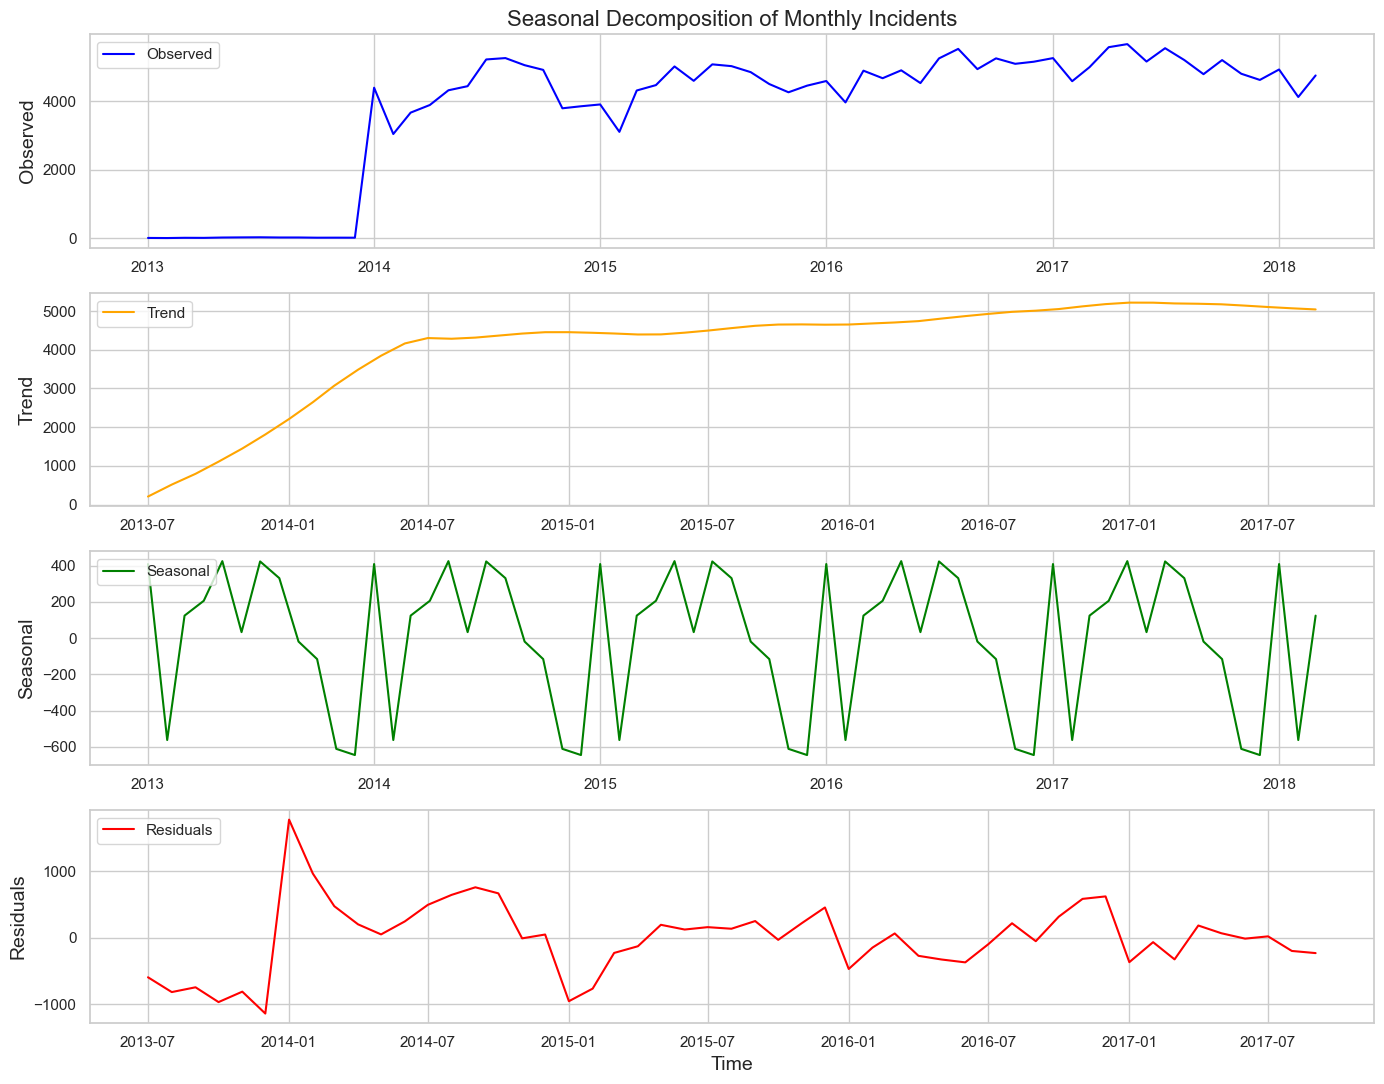

In [745]:
plot_seasonal_decomposition(ts, column_name="total", model='additive', period=12)

### PCF and APCF

**PCF (Partial Correlation Function)** measures the correlation between a time series and its lagged values, removing the influence of shorter lags. It helps to identify the direct relationship at a specific lag while accounting for the effects of intermediate lags.

**APCF (Autocorrelation of Partial Correlation Function)** is a higher-order autocorrelation measure that examines the autocorrelation of residuals after removing the effects of previous lags. It is used to diagnose further dependencies in the residuals of time series models, although it is less commonly applied than PCF.

In [747]:
def plot_acf_pacf(ts_diff, lags=30):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    plot_acf(ts_diff, lags=lags, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")
    plot_pacf(ts_diff, lags=lags, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    
    plt.tight_layout()
    plt.show()

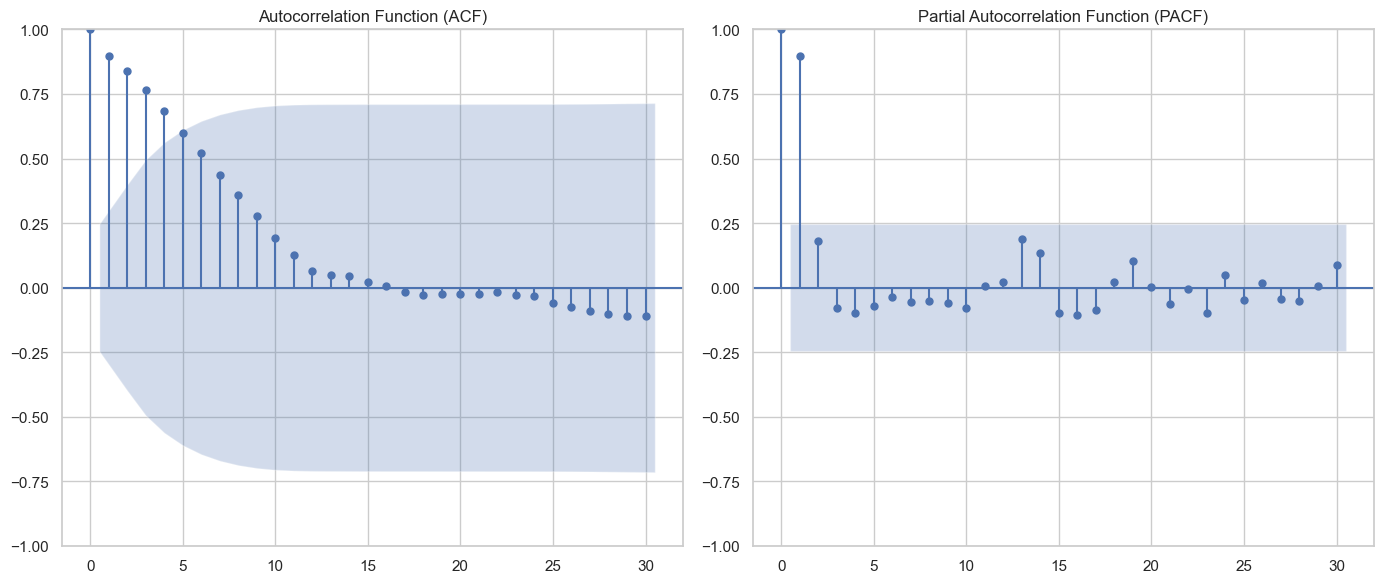

In [748]:
plot_acf_pacf(ts, lags=30)

### Time Series Analysis

#### **ARIMA vs. SARIMA vs. SARIMAX**
**ARIMA:**

- Stands for AutoRegressive Integrated Moving Average.
- Models only the time series data without any seasonal components.
- Best suited for non-seasonal, stationary time series.

**SARIMA:**

- Stands for Seasonal ARIMA.
- Adds a seasonal component to ARIMA to handle recurring patterns over fixed intervals (e.g., yearly seasonality for monthly data with m=12).
- Does not include exogenous variables.

**SARIMAX:**

- Stands for Seasonal ARIMA with eXogenous variables.
- Extends SARIMA by incorporating exogenous variables (independent predictors influencing the dependent time series).
- If you are not using exogenous variables, SARIMA is sufficient.

In [751]:
y_train, y_test = ts['total'].iloc[:-12], ts['total'].iloc[-12:]

The following code uses the **`auto_arima`** function to automatically select the best ARIMA model for your time series data (`ts['total']`). It fits a seasonal ARIMA model by specifying **`seasonal=True`** and **`m=12`**, indicating monthly data with yearly seasonality. The **`stepwise=True`** option efficiently searches through possible models, while **`trace=True`** provides feedback on the models being tested. **`error_action="ignore"`** ensures that errors in model fitting don't stop the process, and **`suppress_warnings=True`** suppresses warnings for cleaner output. The **`model.summary()`** prints the selected model's details, including coefficients and fit statistics like AIC and BIC.

In [753]:
model = auto_arima(
    ts['total'],
    seasonal=True,
    m=12,
    stepwise=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    random_state=42
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=996.747, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=995.423, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=989.734, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=991.090, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=994.121, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=990.459, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=990.732, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=990.622, Time=0.27 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=990.348, Time=0.08 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=992.792, Time=0.28 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=992.500, Time=0.12 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=991.710, Time=0.22 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=991.726, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=990.401, Time=0.14 sec
 ARIMA(2,1,1)(1,0,0)[12] intercep

The output shows that the best model for forecasting is **ARIMA(1,1,0)(1,0,0)[12]**, which includes a first-order autoregressive component and a seasonal autoregressive component with a 12-month period. The AIC value of **988.646** indicates a good fit, while the `Ljung-Box test` suggests no significant autocorrelation in the residuals. However, the `Jarque-Bera test` reveals that the residuals are not normally distributed, and there is evidence of `heteroskedasticity`, meaning the variance of the residuals changes over time. These results suggest the model captures the main patterns, but further improvements may be needed.

In [755]:
sarima_model = ARIMA(y_train, order=model.order, seasonal_order=model.seasonal_order).fit()

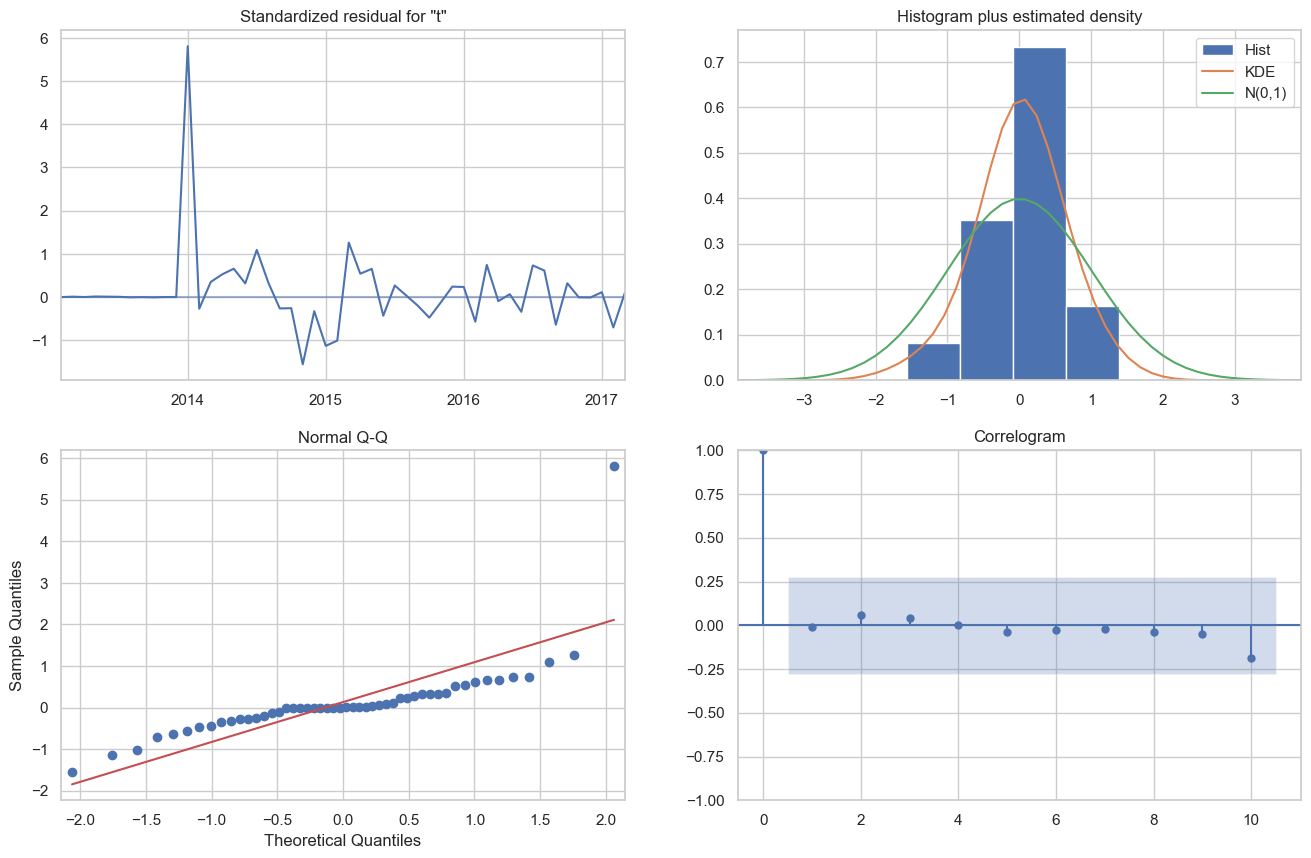

In [756]:
sarima_model.plot_diagnostics(figsize=(16, 10))
plt.show()

In [757]:
forecast = sarima_model.forecast(steps=len(y_test))
forecast = np.array(forecast).flatten()
forecast_series = pd.Series(data=forecast, index=y_test.index)

In [758]:
def evaluate_time_series_model(y_test, forecast_series):
    mae = mean_absolute_error(y_test, forecast_series)
    mse = mean_squared_error(y_test, forecast_series)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, forecast_series)
    r2 = r2_score(y_test, forecast_series)
    
    print("Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
    print(f"R-squared (R²): {r2}")

In [759]:
print("SARIMA Model - Evaluation")
evaluate_time_series_model(y_test, forecast_series)

SARIMA Model - Evaluation
Evaluation Metrics:
Mean Absolute Error (MAE): 360.02961676010597
Mean Squared Error (MSE): 185476.99708188127
Root Mean Squared Error (RMSE): 430.6704042326118
Mean Absolute Percentage Error (MAPE): 0.07
R-squared (R²): 0.0022946639532341884


So, We evaluated the performance of my forecast using two metrics: `MAPE (Mean Absolute Percentage Error)` and `RMSE (Root Mean Squared Error)`.

`MAPE` tells us, on average, how far off our forecast is from the actual values in terms of percentage. In our case, we have a MAPE of 7%. This means that, on average, our forecasted values are 7% away from the actual incidents. Generally, a MAPE below 10% is considered excellent for forecasting, so this is a pretty strong result. It indicates that the model is performing well in terms of accuracy.

`RMSE` measures the average magnitude of errors in the same units as the data (so, in this case, the number of incidents). We got an RMSE of 430.67. This means that, on average, the forecasted number of incidents differs from the actual number of incidents by around 430. Of course, the significance of this value depends on the scale of the data, if the incidents usually vary in the hundreds or thousands, then an RMSE of 430 might be acceptable.

**In summary:**

- A MAPE of 7% shows our forecasts are very close to the actual values on average.
- An RMSE of 430.67 gives us a sense of the absolute size of the errors, which seems reasonable given the context of the data.
So, overall, the model is doing a great job with a fairly accurate forecast.

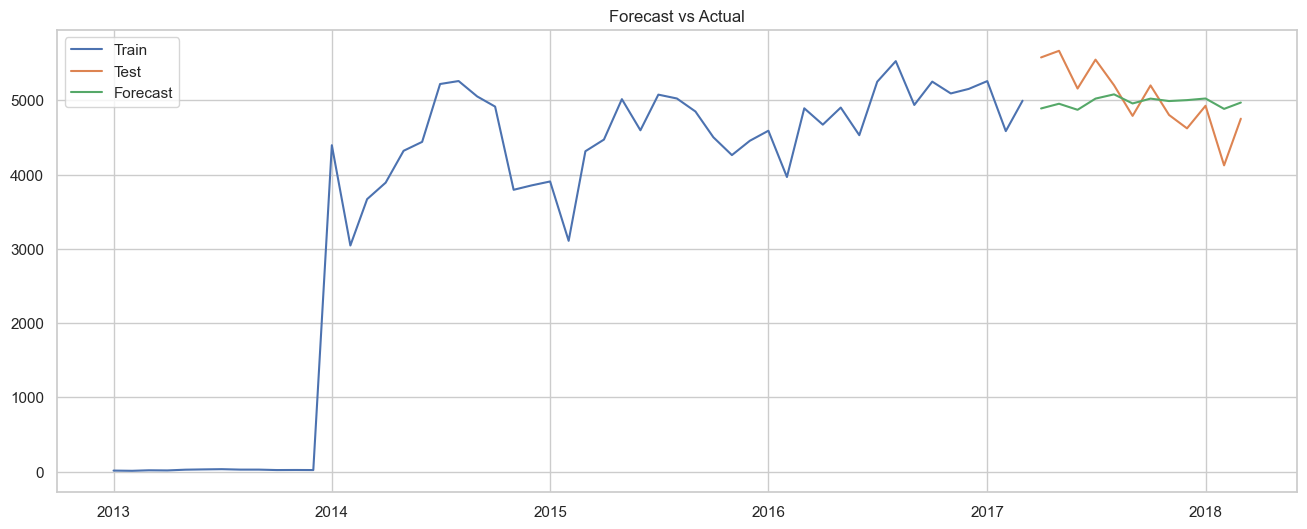

In [761]:
plt.figure(figsize=(16, 6))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(forecast_series, label='Forecast')
plt.title("Forecast vs Actual")
plt.legend()
plt.show()

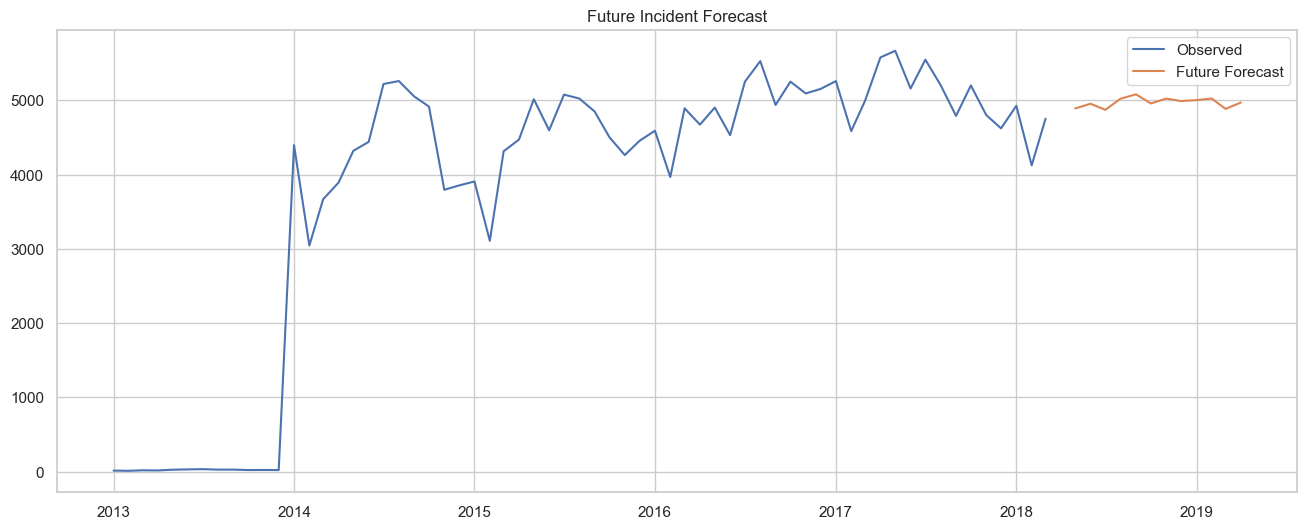

In [762]:
future_forecast = sarima_model.forecast(steps=12)
future_forecast = np.array(future_forecast).flatten()
future_forecast_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq='M')
future_forecast_series = pd.Series(data=future_forecast, index=future_forecast_index)

plt.figure(figsize=(16, 6))
plt.plot(ts['total'], label='Observed')
plt.plot(future_forecast_series, label='Future Forecast')
plt.title("Future Incident Forecast")
plt.legend()
plt.show()

### Using Prophet for Forecasting

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [764]:
df_prophet = monthly_incidents.reset_index()
df_prophet.columns = ['ds', 'y']

In [765]:
train_data = df_prophet.iloc[:-12]
test_data = df_prophet.iloc[-12:]

In [766]:
model_prophet = Prophet()
model_prophet.fit(train_data)

21:30:55 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing


In [767]:
forecast_test = model_prophet.predict(test_data)

In [768]:
predicted = forecast_test.loc[forecast_test['ds'].isin(test_data['ds']), 'yhat'].values

In [769]:
actual = test_data['y'].values

In [770]:
print("Prophet Model - Evaluation")
evaluate_time_series_model(actual, predicted)

Prophet Model - Evaluation
Evaluation Metrics:
Mean Absolute Error (MAE): 2022.1861812037005
Mean Squared Error (MSE): 4423159.914665829
Root Mean Squared Error (RMSE): 2103.130978961089
Mean Absolute Percentage Error (MAPE): 0.41
R-squared (R²): -22.792763083726623


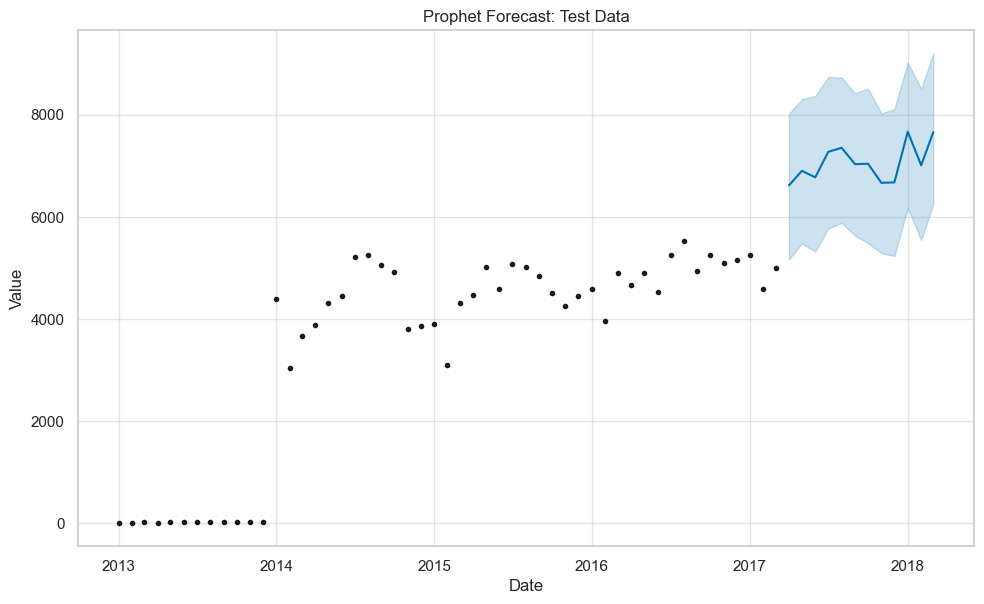

In [771]:
fig = model_prophet.plot(forecast_test)

plt.title("Prophet Forecast: Test Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

Retraining the model completely

In [773]:
model_prophet_full = Prophet()
model_prophet_full.fit(df_prophet)

21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:56 - cmdstanpy - INFO - Chain [1] done processing


In [774]:
future = model_prophet_full.make_future_dataframe(periods=12, freq='M', include_history = True)

In [775]:
forecast_prophet = model_prophet_full.predict(future)

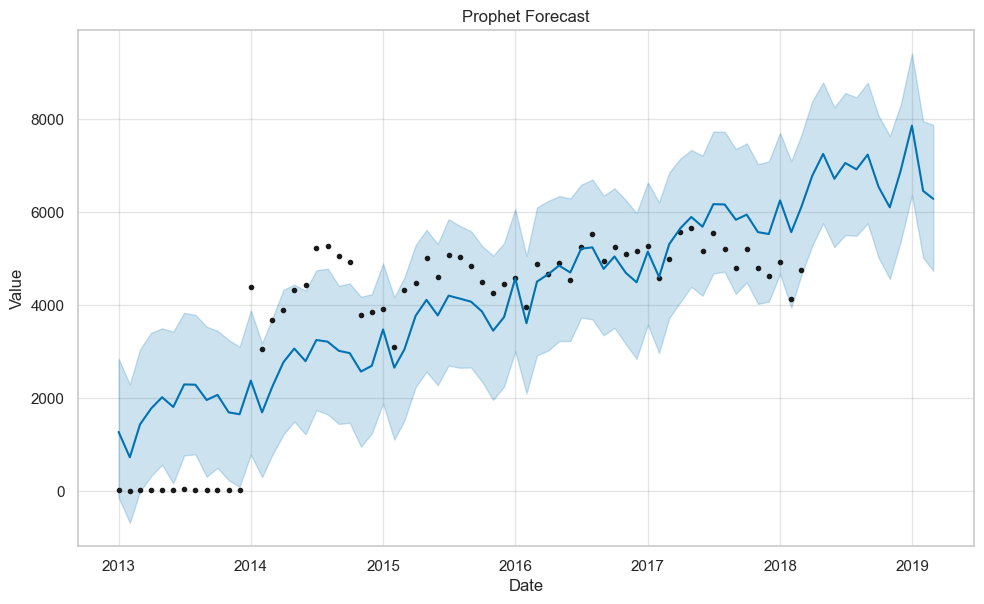

In [776]:
fig = model_prophet_full.plot(forecast_prophet)

plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

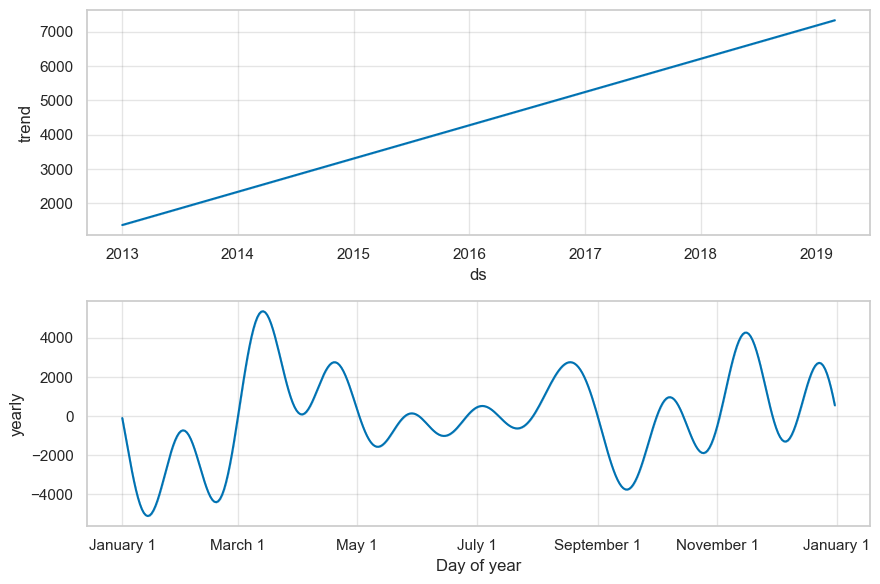

In [777]:
fig2 = model_prophet_full.plot_components(forecast_prophet)

In [778]:
plot_plotly(model_prophet_full, forecast_prophet)

In [779]:
plot_components_plotly(model_prophet_full, forecast_prophet)

In [780]:
map_baseline = mean_absolute_percentage_error(forecast_prophet.yhat, forecast_prophet.yhat_upper)

In [781]:
print(f"Mean Absolute Percentage Error (MAPE) for the Future Forecasted Data: {map_baseline:.2f}")

Mean Absolute Percentage Error (MAPE) for the Future Forecasted Data: 0.46


Cross Validation and more!!!

Initial thoughts, Prophet is not performing good compared to our SARIMA model. may try using holidays and see!

Will try to investigate what is causing the issue.

### Using LSTM(Long Short-Term Memory) for forecasting

In [785]:
data = monthly_incidents.values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [786]:
monthly_incidents

monthyear
2013-01-01      15
2013-02-01      12
2013-03-01      19
2013-04-01      17
2013-05-01      27
              ... 
2017-11-01    4802
2017-12-01    4622
2018-01-01    4926
2018-02-01    4124
2018-03-01    4752
Freq: MS, Length: 63, dtype: int64

In [787]:
def create_time_steps(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step):
        x.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

In [788]:
time_step = 12
x, y = create_time_steps(data_scaled, time_step)

In [789]:
x = x.reshape(x.shape[0], x.shape[1], 1)

In [790]:
train_size = int(len(x) * 0.8)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

In [791]:
model_lstm = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),

    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    
    Dense(units=1)
])

In [792]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [793]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 12, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 12, 50)            20200     
                                                                 
 dropout_13 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 12, 50)            20200     
                                                                 
 dropout_14 (Dropout)        (None, 12, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

In [794]:
history = model_lstm.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
2/2 [==============================] - 2s 451ms/step - loss: 0.6728 - val_loss: 0.6463
Epoch 2/50
2/2 [==============================] - 0s 19ms/step - loss: 0.5663 - val_loss: 0.4868
Epoch 3/50
2/2 [==============================] - 0s 19ms/step - loss: 0.4413 - val_loss: 0.2946
Epoch 4/50
2/2 [==============================] - 0s 18ms/step - loss: 0.2981 - val_loss: 0.0886
Epoch 5/50
2/2 [==============================] - 0s 16ms/step - loss: 0.1319 - val_loss: 0.0198
Epoch 6/50
2/2 [==============================] - 0s 16ms/step - loss: 0.0641 - val_loss: 0.2134
Epoch 7/50
2/2 [==============================] - 0s 16ms/step - loss: 0.1440 - val_loss: 0.1309
Epoch 8/50
2/2 [==============================] - 0s 14ms/step - loss: 0.0913 - val_loss: 0.0248
Epoch 9/50
2/2 [==============================] - 0s 14ms/step - loss: 0.0498 - val_loss: 0.0063
Epoch 10/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0404 - val_loss: 0.0192
Epoch 11/50
2/2 [===========

In [795]:
predicted = model_lstm.predict(x_test)

1/1 [==============================] - 0s 406ms/step


In [796]:
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [797]:
print("LSTM Model - Evaluation")
evaluate_time_series_model(y_test_actual, predicted)

LSTM Model - Evaluation
Evaluation Metrics:
Mean Absolute Error (MAE): 344.28750887784093
Mean Squared Error (MSE): 176236.46722735057
Root Mean Squared Error (RMSE): 419.8052729865962
Mean Absolute Percentage Error (MAPE): 0.07
R-squared (R²): -0.017622562135727105


In [798]:
future_steps = 12
future_predictions = []
last_sequence = x_test[-1]

for _ in range(future_steps):
    next_pred = model_lstm.predict(last_sequence.reshape(1, time_step, 1))[0]
    future_predictions.append(next_pred)
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(time_step, 1)

1/1 [==============================] - 0s 6ms/step


In [799]:
future_predictions = scaler.inverse_transform(np.array(future_predictions))
all_predictions = np.concatenate((data[:train_size], predicted, future_predictions), axis=0)

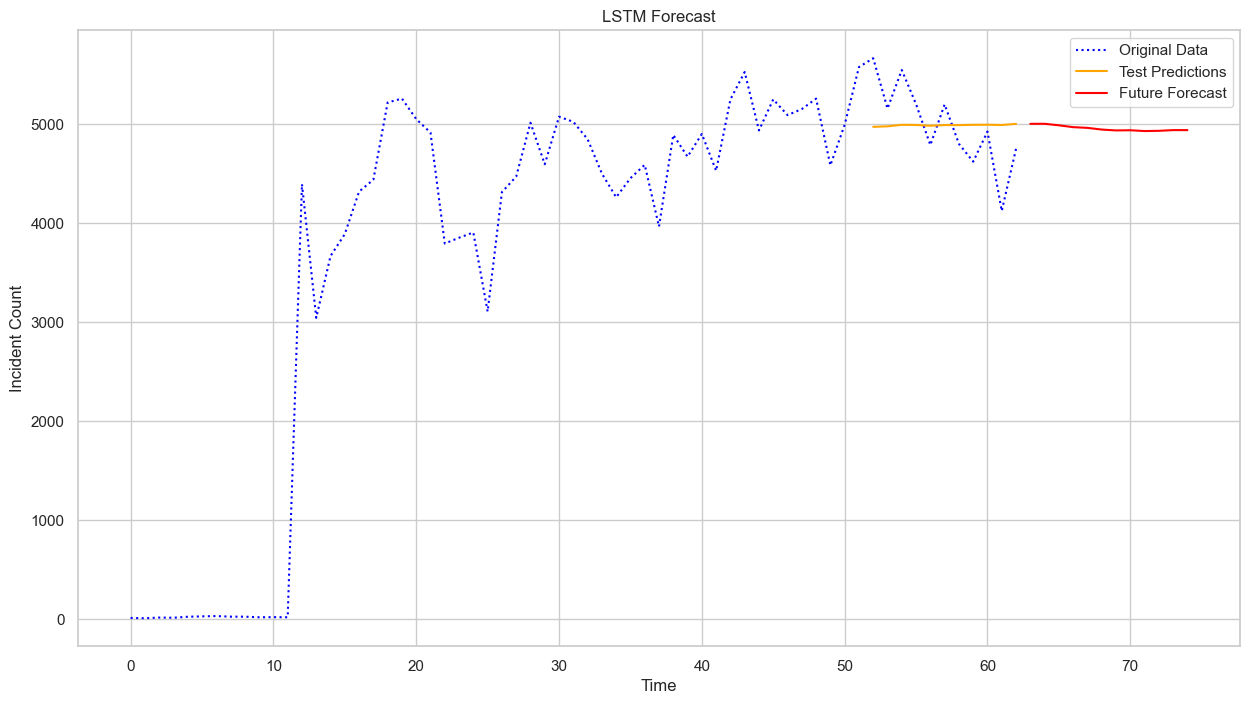

In [800]:
plt.figure(figsize=(15, 8))
original_data = scaler.inverse_transform(data_scaled)
plt.plot(range(len(original_data)), original_data, label='Original Data', linestyle='dotted', color='blue')

test_start = train_size + time_step
test_end = test_start + len(predicted)
plt.plot(range(test_start, test_end), predicted, label='Test Predictions', color='orange')

future_start = len(data)
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_predictions, label='Future Forecast', color='red')

plt.legend()
plt.title('LSTM Forecast')
plt.xlabel('Time')
plt.ylabel('Incident Count')
plt.show()

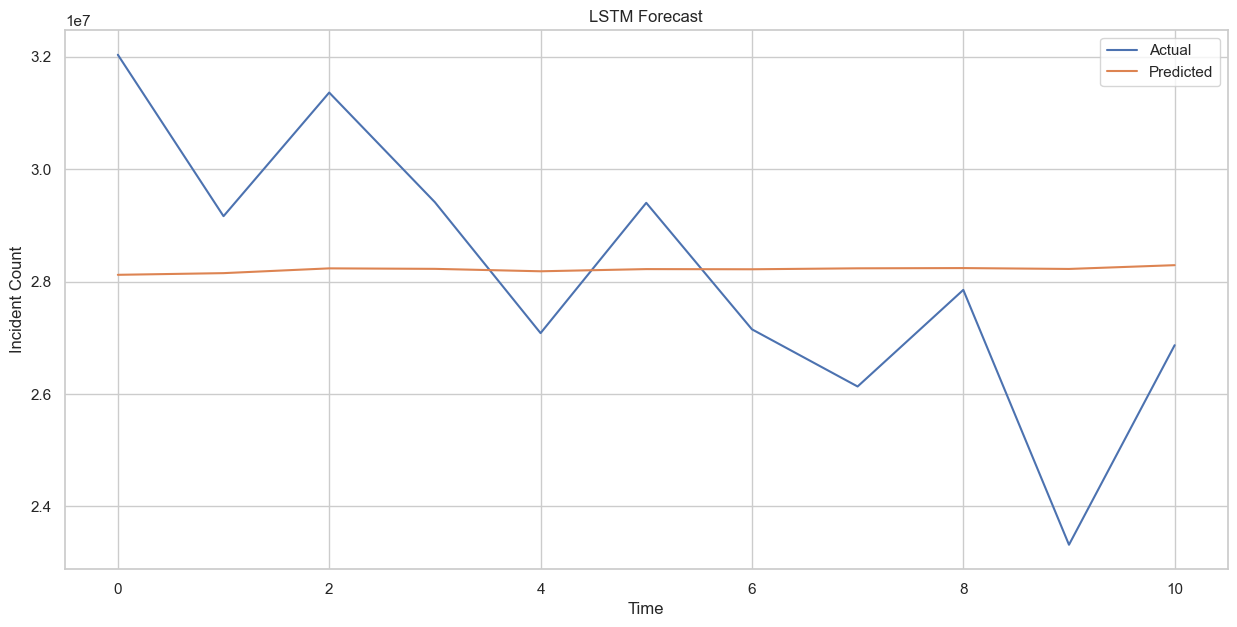

In [801]:
plt.figure(figsize=(15, 7))
y_test_actual_inv = scaler.inverse_transform(y_test_actual.reshape(-1, 1))
predicted_inv = scaler.inverse_transform(predicted)

plt.plot(y_test_actual_inv, label='Actual')
plt.plot(predicted_inv, label='Predicted')

plt.legend()
plt.title('LSTM Forecast')
plt.xlabel('Time')
plt.ylabel('Incident Count')
plt.show()

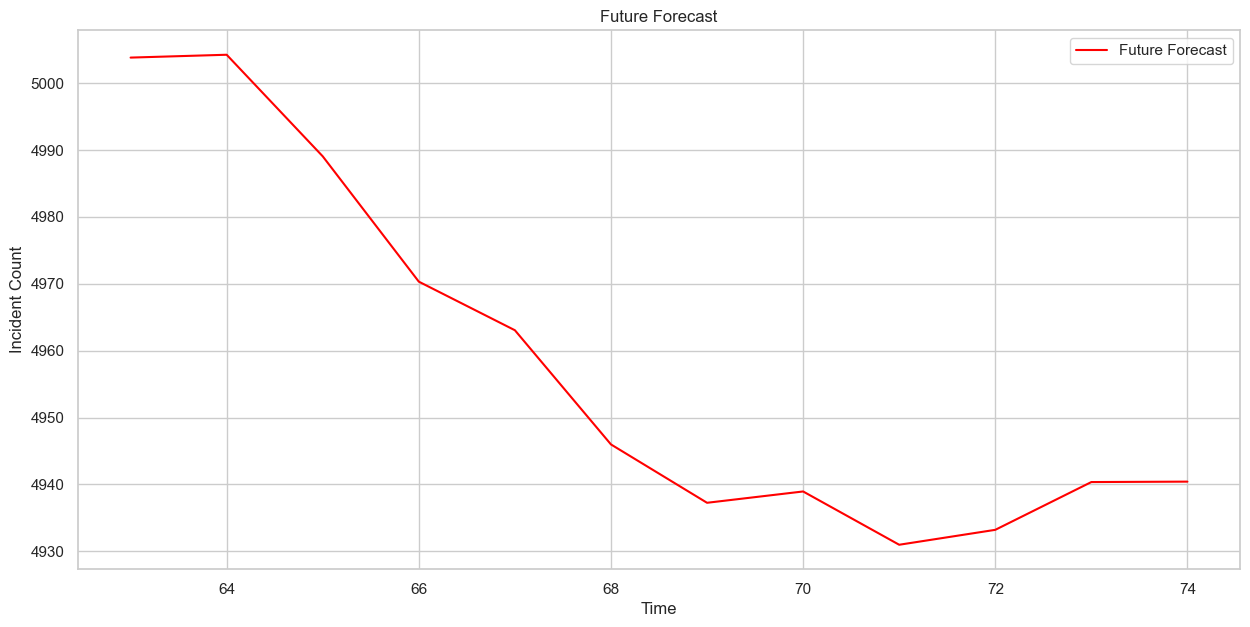

In [802]:
plt.figure(figsize=(15, 7))

future_start = len(data)
future_end = future_start + future_steps

plt.plot(range(future_start, future_end), future_predictions, label='Future Forecast', color='red')

plt.legend()
plt.title('Future Forecast')
plt.xlabel('Time')
plt.ylabel('Incident Count')
plt.show()

## Weekly Time Series Analysis

### SARIMA Model

In [805]:
weekly_timeseries_df = time_series_df.copy()

In [806]:
weekly_timeseries_df['date'] = pd.to_datetime(weekly_timeseries_df['date'])
weekly_timeseries_df = weekly_timeseries_df.drop("monthyear", axis=1)
weekly_timeseries_df.set_index('date', inplace=True)

In [807]:
weekly_data = weekly_timeseries_df.resample('W').count()

weekly_data.reset_index(inplace=True)
weekly_data.rename(columns={'date': 'ds', 'incident_id': 'y'}, inplace=True)

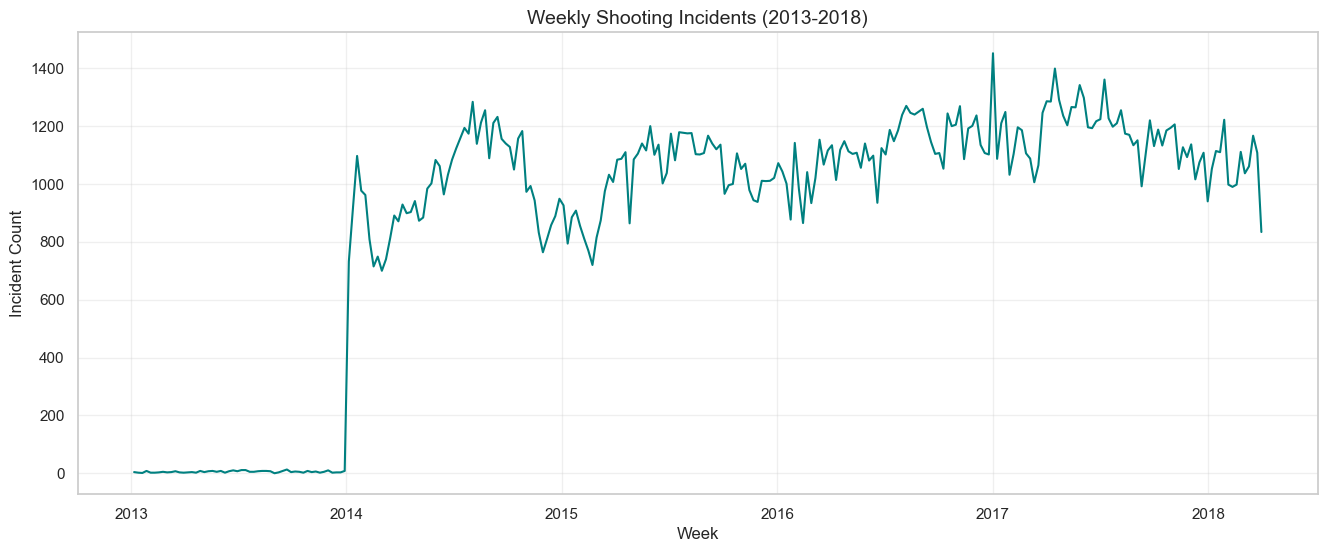

In [808]:
plt.figure(figsize=(16, 6))
plt.plot(weekly_data['ds'], weekly_data['y'], linestyle='-', color='teal')
plt.title("Weekly Shooting Incidents (2013-2018)", fontsize=14)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Incident Count", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [809]:
perform_adf_test(weekly_data['y'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -2.0788876575947253
p-value: 0.25308827513896226
#Lags Used: 5
Number of Observations Used: 268

Critical Values:
    1%: -3.454988209954765
    5%: -2.8723857312734613
    10%: -2.572549407997327

Conclusion: Weak evidence against the null hypothesis (H0), suggesting the data is non-stationary.


In [810]:
if adfuller(weekly_data['y'])[1] > 0.05:
    weekly_diff = weekly_data['y'].diff().dropna()
    perform_adf_test(ts_diff)
else:
    weekly_diff = weekly_data['y']

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -10.757236994842238
p-value: 2.5744632543964214e-19
#Lags Used: 0
Number of Observations Used: 61

Critical Values:
    1%: -3.542412746661615
    5%: -2.910236235808284
    10%: -2.5927445767266866

Conclusion: Strong evidence against the null hypothesis (H0), suggesting the data is stationary.


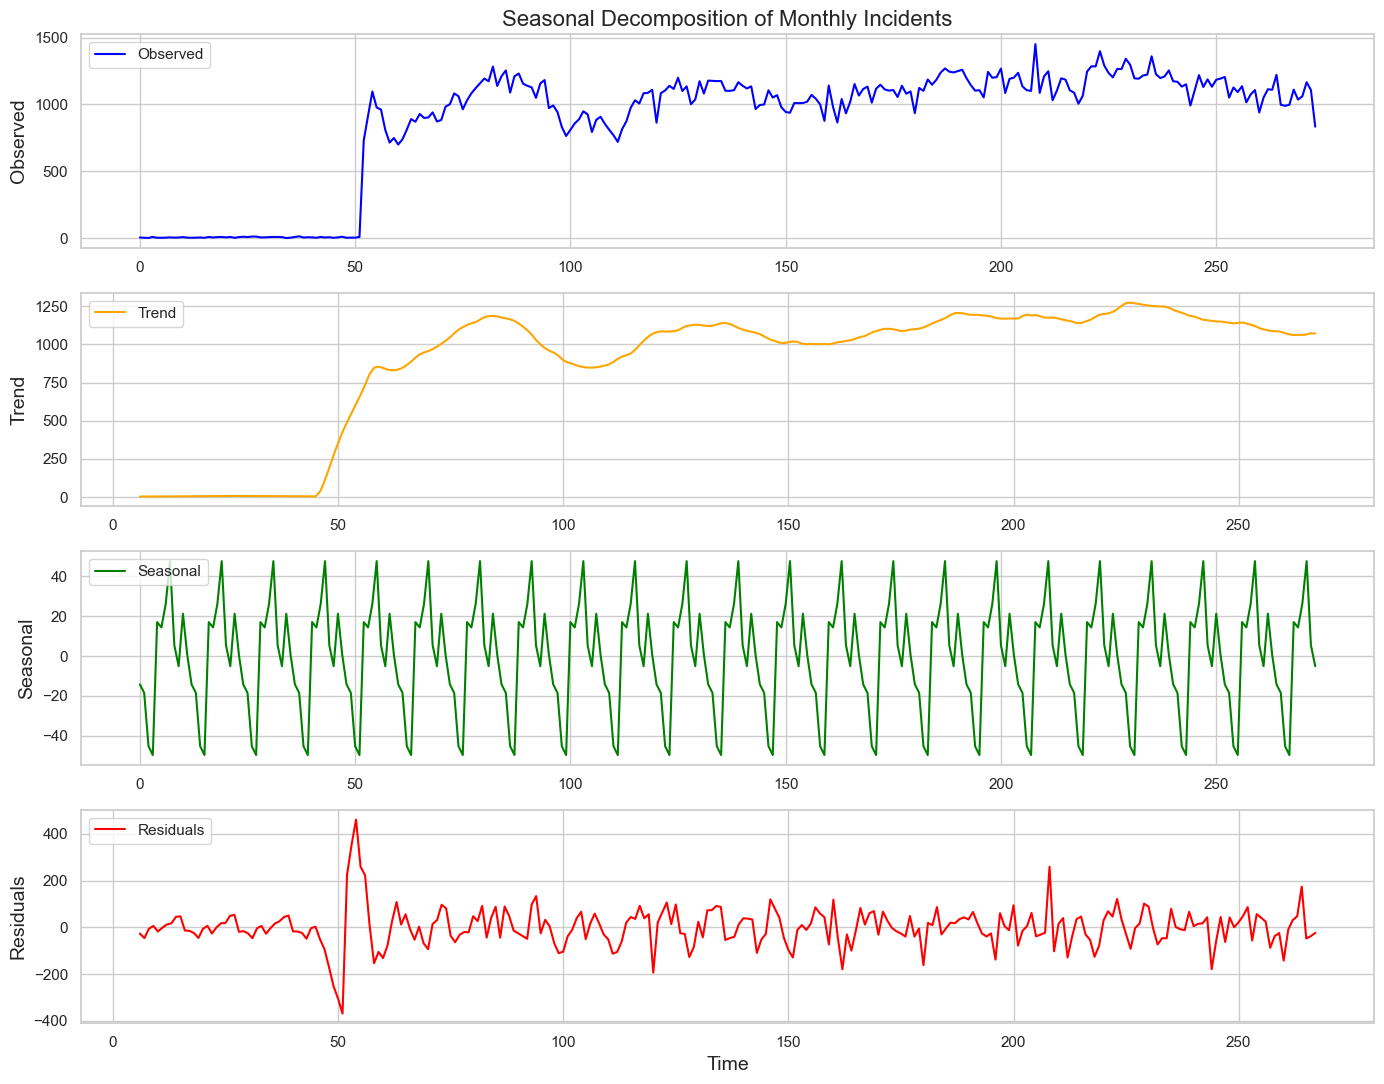

In [811]:
plot_seasonal_decomposition(weekly_data, column_name="y", model='additive', period=12)

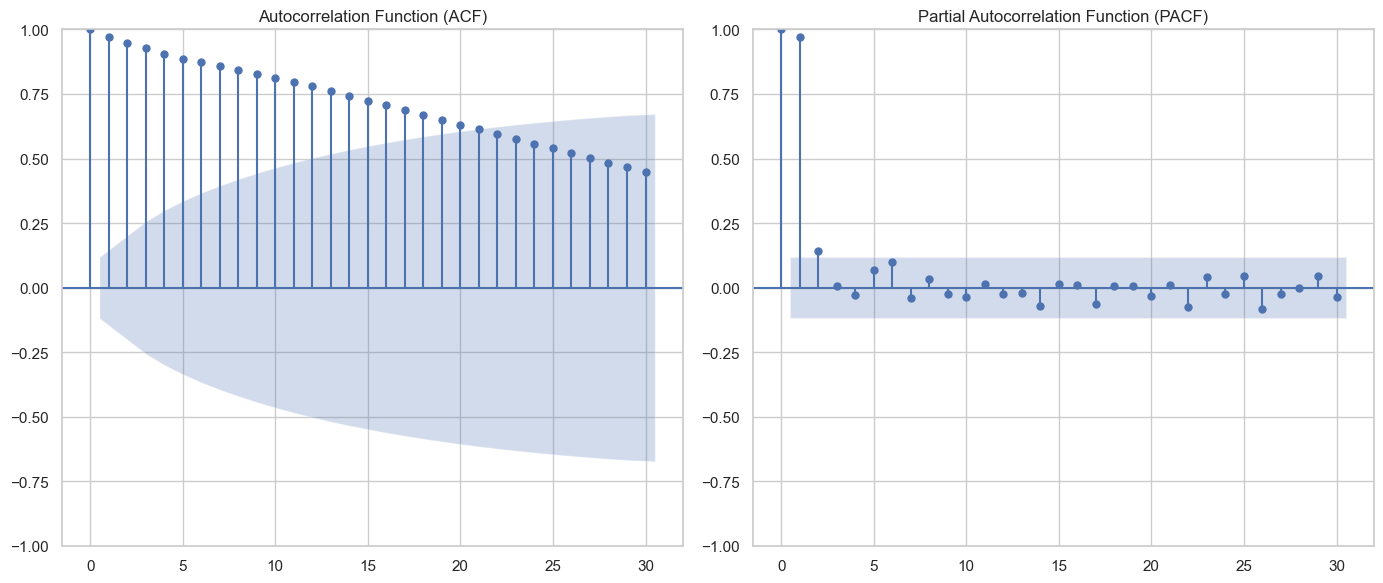

In [812]:
plot_acf_pacf(weekly_data["y"], lags=30)

In [813]:
# Weekly SARIMA Model
w_train, w_test = weekly_data['y'][:-52], weekly_data['y'][-52:]

In [814]:
w_model = auto_arima(
    w_train,
    seasonal=True,
    m=52,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=5.21 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2647.123, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2643.304, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2643.637, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2645.934, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2641.347, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=2643.311, Time=0.53 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=2645.155, Time=2.42 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=2643.353, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2643.344, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2641.646, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=2645.343, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[52]             : AIC=2640.513, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52]             : AIC=2642.486, Time=0.46 sec
 ARIMA(1,1,0)(0,0,1)[52]

In [815]:
print(w_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1318.257
Date:                Thu, 21 Nov 2024   AIC                           2640.513
Time:                        21:31:15   BIC                           2647.310
Sample:                             0   HQIC                          2643.258
                                - 222                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1813      0.033     -5.547      0.000      -0.245      -0.117
sigma2      8923.2206    283.046     31.526      0.000    8368.460    9477.981
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [816]:
w_sarima_model = ARIMA(w_train, order=w_model.order, seasonal_order=w_model.seasonal_order).fit()

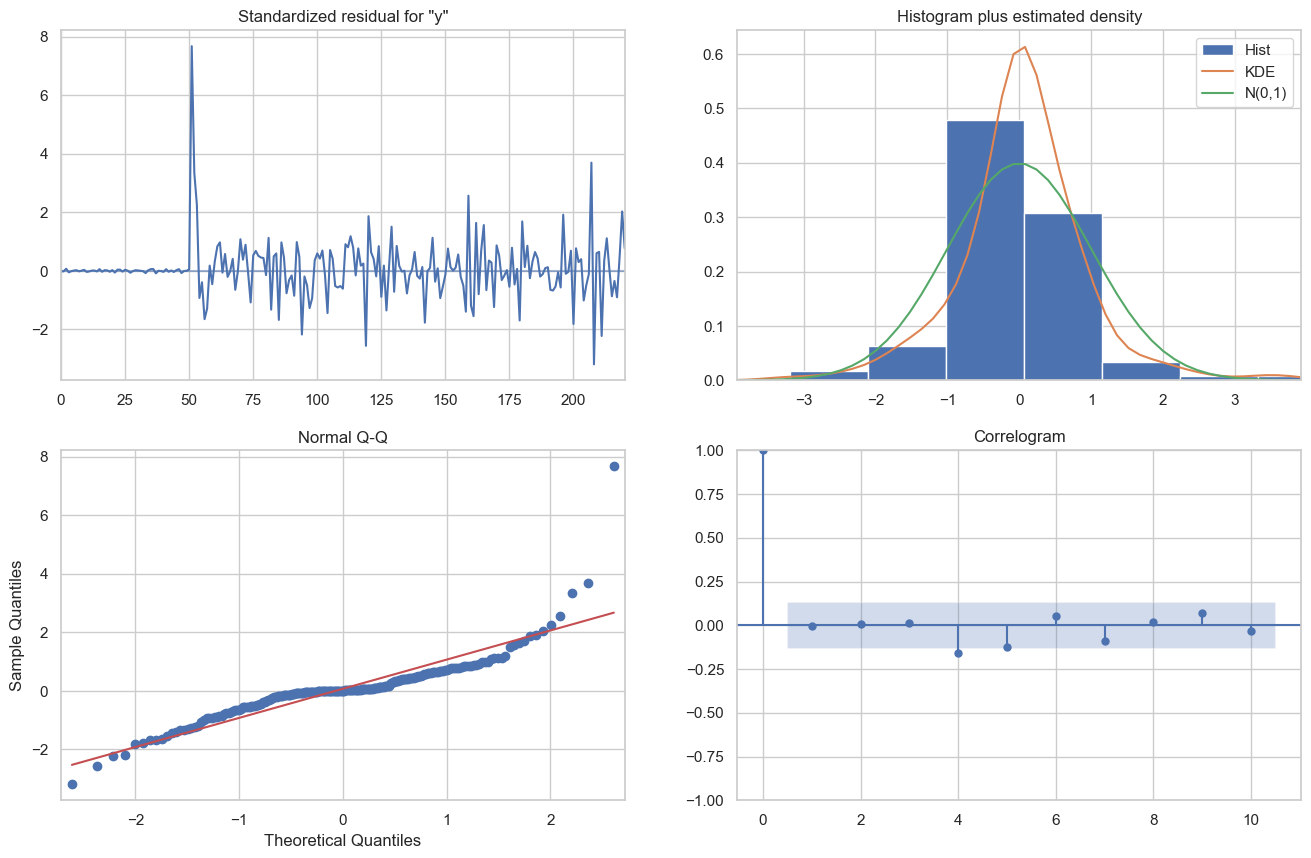

In [817]:
w_sarima_model.plot_diagnostics(figsize=(16, 10))
plt.show()

In [818]:
w_forecast = w_sarima_model.forecast(steps=len(w_test))
w_forecast = np.array(w_forecast).flatten()
w_forecast_series = pd.Series(data=w_forecast, index=w_test.index)

In [819]:
print("SARIMA Model - Evaluation")
evaluate_time_series_model(w_test, w_forecast_series)

SARIMA Model - Evaluation
Evaluation Metrics:
Mean Absolute Error (MAE): 137.44909381038835
Mean Squared Error (MSE): 27692.91880579282
Root Mean Squared Error (RMSE): 166.4118950249435
Mean Absolute Percentage Error (MAPE): 0.13
R-squared (R²): -1.344058220603059


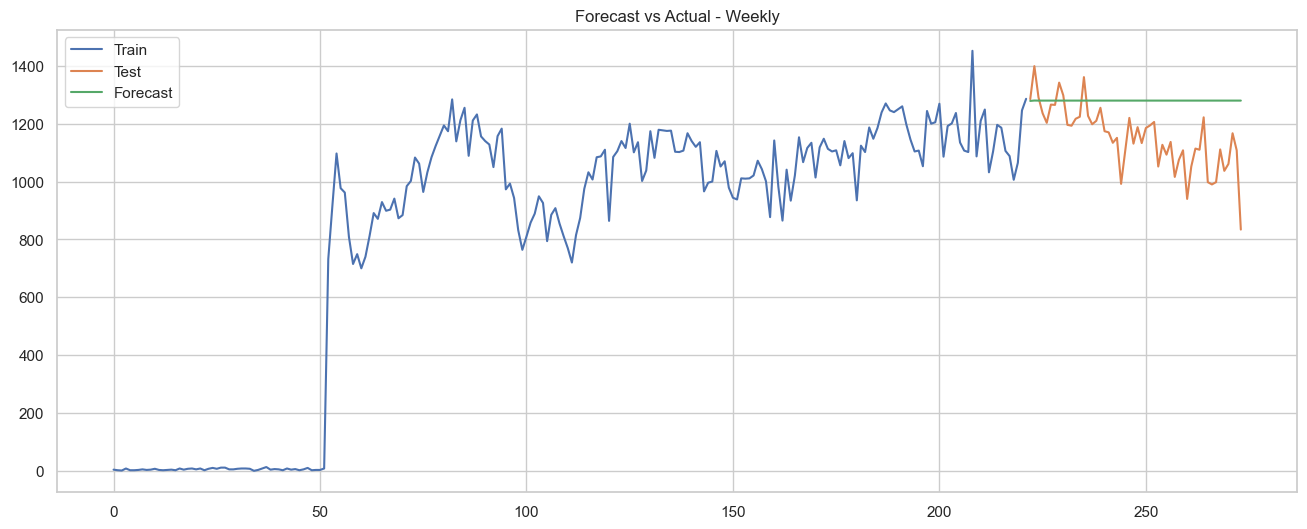

In [820]:
plt.figure(figsize=(16, 6))
plt.plot(w_train, label='Train')
plt.plot(w_test, label='Test')
plt.plot(w_forecast_series, label='Forecast')
plt.title("Forecast vs Actual - Weekly")
plt.legend()
plt.show()

In [821]:
last_date = weekly_data.index[-1]

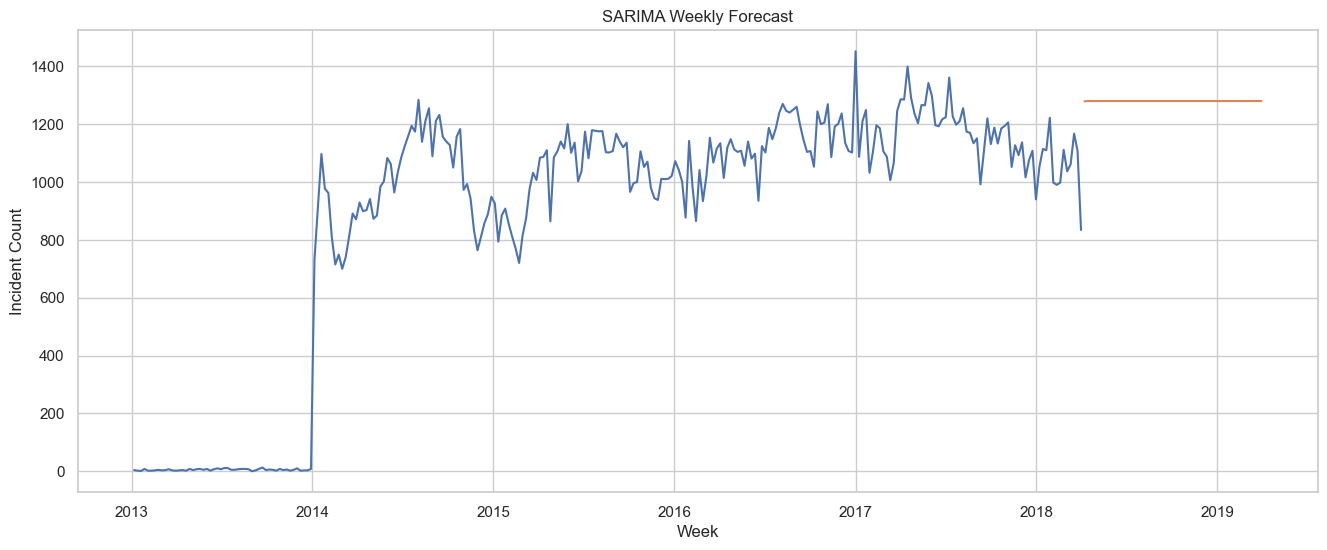

In [822]:
w_future_forecast = w_sarima_model.forecast(steps=52)
w_future_forecast = np.array(w_future_forecast).flatten()
w_future_forecast_index = pd.date_range(start=weekly_data['ds'].iloc[-1] + pd.DateOffset(weeks=1), periods=52, freq='W')
w_future_forecast_series = pd.Series(data=w_future_forecast, index=w_future_forecast_index)

plt.figure(figsize=(16, 6))
plt.plot(weekly_data['ds'], weekly_data['y'], label='Observed')
plt.plot(w_future_forecast_series, label='Future Forecast')
plt.title("SARIMA Weekly Forecast")
plt.xlabel("Week")
plt.ylabel("Incident Count")
plt.show()

While the MAPE is low, which suggests that in relative terms, the predictions are close to the actual values, the MAE, MSE, and RMSE are quite high, and the negative R² is a strong indication that the model is not fitting the data well.

### Prophet Model

In [825]:
prophet_weekly_data = weekly_data[['ds', 'y']]

In [826]:
w_train_data = prophet_weekly_data.iloc[:-52]
w_test_data = prophet_weekly_data.iloc[-52:]

In [827]:
w_prophet_model = Prophet()
w_prophet_model.fit(w_train_data)

21:31:15 - cmdstanpy - INFO - Chain [1] start processing
21:31:15 - cmdstanpy - INFO - Chain [1] done processing


In [828]:
w_forecast_test = w_prophet_model.predict(w_test_data)

In [958]:
w_predicted_proph = w_forecast_test.loc[w_forecast_test['ds'].isin(w_test_data['ds']), 'yhat'].values

In [960]:
w_actual = w_test_data['y'].values

In [962]:
print("Prophet Model - Evaluation")
evaluate_time_series_model(w_actual, w_predicted_proph)

Prophet Model - Evaluation
Evaluation Metrics:
Mean Absolute Error (MAE): 146.1489798629514
Mean Squared Error (MSE): 27571.53998241112
Root Mean Squared Error (RMSE): 166.04680057866554
Mean Absolute Percentage Error (MAPE): 0.13
R-squared (R²): -1.3337841490705382


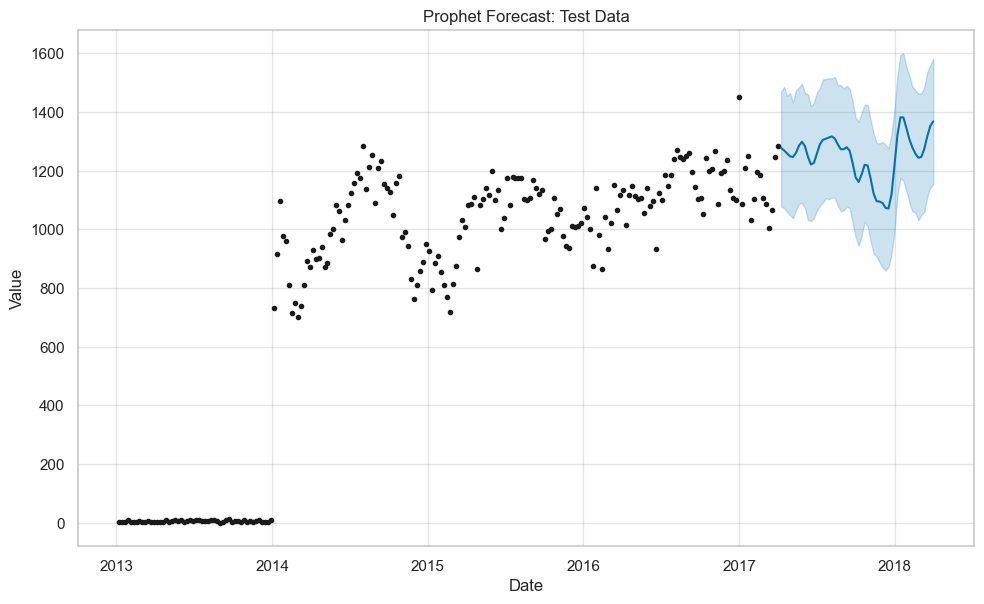

In [956]:
fig = w_prophet_model.plot(w_forecast_test)

plt.title("Prophet Forecast: Test Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

In [833]:
w_model_prophet_full = Prophet()
w_model_prophet_full.fit(prophet_weekly_data)

21:31:15 - cmdstanpy - INFO - Chain [1] start processing
21:31:15 - cmdstanpy - INFO - Chain [1] done processing


In [834]:
wp_future = w_model_prophet_full.make_future_dataframe(periods=52, freq='W', include_history = True)
wp_forecast = w_model_prophet_full.predict(wp_future)

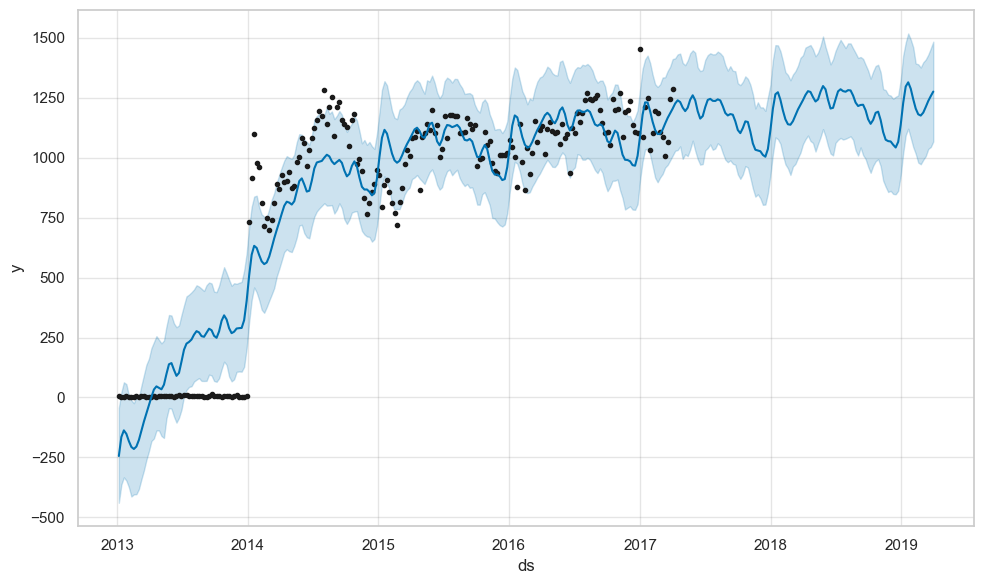

In [835]:
fig = w_prophet_model.plot(wp_forecast)
plt.show()

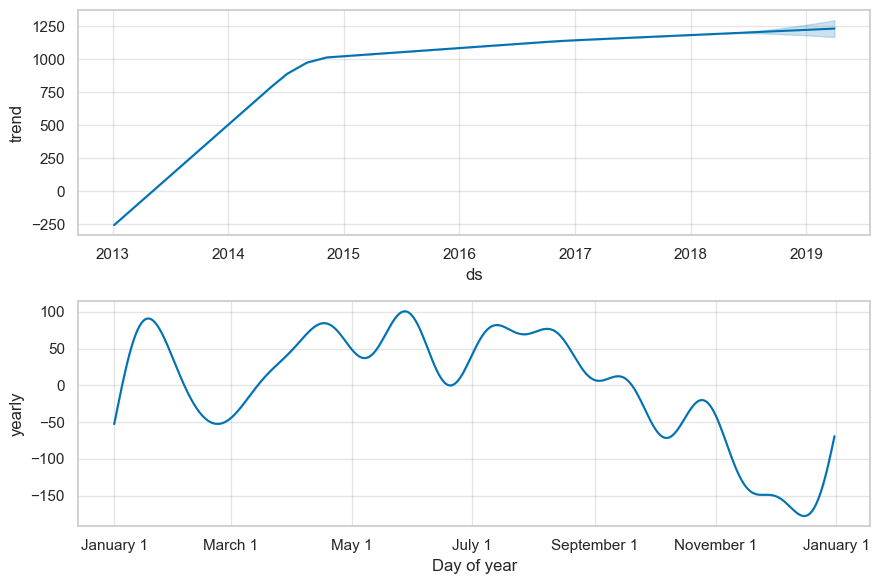

In [836]:
wfig2 = w_model_prophet_full.plot_components(wp_forecast)

In [837]:
w_map_baseline = mean_absolute_percentage_error(wp_forecast.yhat, wp_forecast.yhat_upper)

In [838]:
print(f"Mean Absolute Percentage Error (MAPE) for the Future Forecasted Data: {w_map_baseline:.2f}")

Mean Absolute Percentage Error (MAPE) for the Future Forecasted Data: 0.72


In [839]:
evaluate_time_series_model(wp_forecast.yhat, wp_forecast.yhat_upper)

Evaluation Metrics:
Mean Absolute Error (MAE): 194.59728063203974
Mean Squared Error (MSE): 37937.92924467516
Root Mean Squared Error (RMSE): 194.77661370060616
Mean Absolute Percentage Error (MAPE): 0.72
R-squared (R²): 0.7474145334717096


### LSTM 

New ideas

- Monthly to Weekly
- Cross Validation?
- Adding Holidays
- Location and Timeseries
- Any other features? - like age, gender